In [70]:
import pandas as pd
from gurobipy import *

### Aufgabe 1
a) Download und Visualisierung der Daten (01.01.2019 - 31.12.2019)

In [71]:
import os
os.getcwd()

'c:\\Users\\Dominik\\Desktop\\Master_KIT\\Smart Grid Applications\\Übungen_SmartGridApplications'

In [72]:
df = pd.read_excel("Uebung01/Großhandelspreise_2019.xlsx")
pv = pd.read_csv("Uebung01/PV_2019.csv")
wind = pd.read_csv("Uebung01/wind_2019.csv")

df.head(3)

,Datum,Uhrzeit,Deutschland/Luxemburg[€/MWh],∅ Anrainer DE/LU[€/MWh],Belgien[€/MWh],Dänemark 1[€/MWh],Dänemark 2[€/MWh],Frankreich[€/MWh],Niederlande[€/MWh],Norwegen 2[€/MWh],Österreich[€/MWh],Polen[€/MWh],Schweden 4[€/MWh],Schweiz[€/MWh],Tschechien[€/MWh],DE/AT/LU[€/MWh],Italien (Nord)[€/MWh],Slowenien[€/MWh],Ungarn[€/MWh]
0,01.01.2019,00:00,28.32,-,69.49,28.32,28.32,51.00,68.92,48.77,33.48,-,28.32,50.26,8.5,-,51.00,51.00,59.9
1,01.01.2019,01:00,10.07,-,66.58,10.07,10.07,46.27,64.98,49.25,39.76,-,10.07,48.74,3.97,-,46.27,46.27,52.71
2,01.01.2019,02:00,-4.08,-,65.07,-4.08,-4.08,39.78,60.27,49.17,39.78,-,10.03,47.24,4.7,-,39.78,39.78,36.49


In [73]:
#benötigte Daten in df auswählen
df = df[['Datum', 'Uhrzeit', 'Deutschland/Luxemburg[€/MWh]']]
df = df.rename(columns={"Deutschland/Luxemburg[€/MWh]": "Kosten"})
df.head(3)

,Datum,Uhrzeit,Kosten
0,01.01.2019,00:00,28.32
1,01.01.2019,01:00,10.07
2,01.01.2019,02:00,-4.08


In [74]:
#aus Datum und Uhrzeit -> timestamp erstellen
df['time'] = df.apply(lambda row: row["Datum"] + " " + row["Uhrzeit"], axis = 1) 
df['time'] = pd.to_datetime(df['time'], format ="%d.%m.%Y %H:%M")
df.head(3)

,Datum,Uhrzeit,Kosten,time
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00


In [76]:
wind.head(3)

,time,local_time,electricity
0,2019-01-01 00:00,2019-01-01 01:00,1.038
1,2019-01-01 01:00,2019-01-01 02:00,1.184
2,2019-01-01 02:00,2019-01-01 03:00,1.402


In [77]:
#Problem: electricity von local_time 2019-01-01 00:00 ist nicht gegeben
#Lösung: einfach electricity von 1 für wind und 0 für PV angenommen
first_row = pd.DataFrame({'local_time': [wind.time[0]],
                   'electricity': [1]})
first_row

,local_time,electricity
0,2019-01-01 00:00,1


In [78]:
wind = first_row.append(wind)
wind.head(3)

C:\Users\Dominik\AppData\Local\Temp\ipykernel_1504\954844438.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wind = first_row.append(wind)


,local_time,electricity,time
0,2019-01-01 00:00,1.000,NaN
0,2019-01-01 01:00,1.038,2019-01-01 00:00
1,2019-01-01 02:00,1.184,2019-01-01 01:00


In [80]:
#same for pv
first_row_pv = pd.DataFrame({'local_time': [pv.time[0]],'electricity': [0]})
pv = first_row_pv.append(pv)
pv

,local_time,electricity,time
0,2019-01-01 00:00,0.0,NaN
0,2019-01-01 01:00,0.0,2019-01-01 00:00
1,2019-01-01 02:00,0.0,2019-01-01 01:00
2,2019-01-01 03:00,0.0,2019-01-01 02:00
3,2019-01-01 04:00,0.0,2019-01-01 03:00
...,...,...,...
8755,2019-12-31 20:00,0.0,2019-12-31 19:00
8756,2019-12-31 21:00,0.0,2019-12-31 20:00
8757,2019-12-31 22:00,0.0,2019-12-31 21:00
8758,2019-12-31 23:00,0.0,2019-12-31 22:00


In [81]:
#remove last row wind and pv
wind = wind[:-1]
print('wind shape:',wind.shape)
print('pv shape vorher:', pv.shape)
pv = pv[:-1]
print('pv shape nachher:', pv.shape)

wind = wind.reset_index()
pv = pv.reset_index()

print(df.shape)

wind shape: (8760, 3)
pv shape vorher: (8761, 3)
pv shape nachher: (8760, 3)


In [82]:
df['wind'] = wind.electricity
df['pv'] = pv.electricity
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0


In [84]:
df_show = df[0:1440] #erste zwei Monate (Januar + Februar)

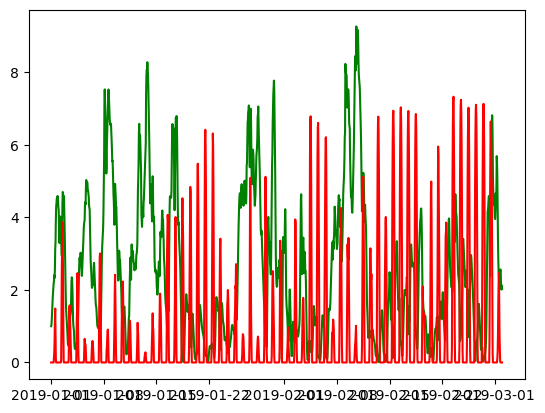

In [85]:
#plt.plot(df_show.time, df_show["Kosten"], label='kosten', color='b')
import matplotlib.pyplot as plt
plt.plot(df_show.time, df_show["wind"], color='g')
plt.plot(df_show.time, df_show["pv"], color='r')


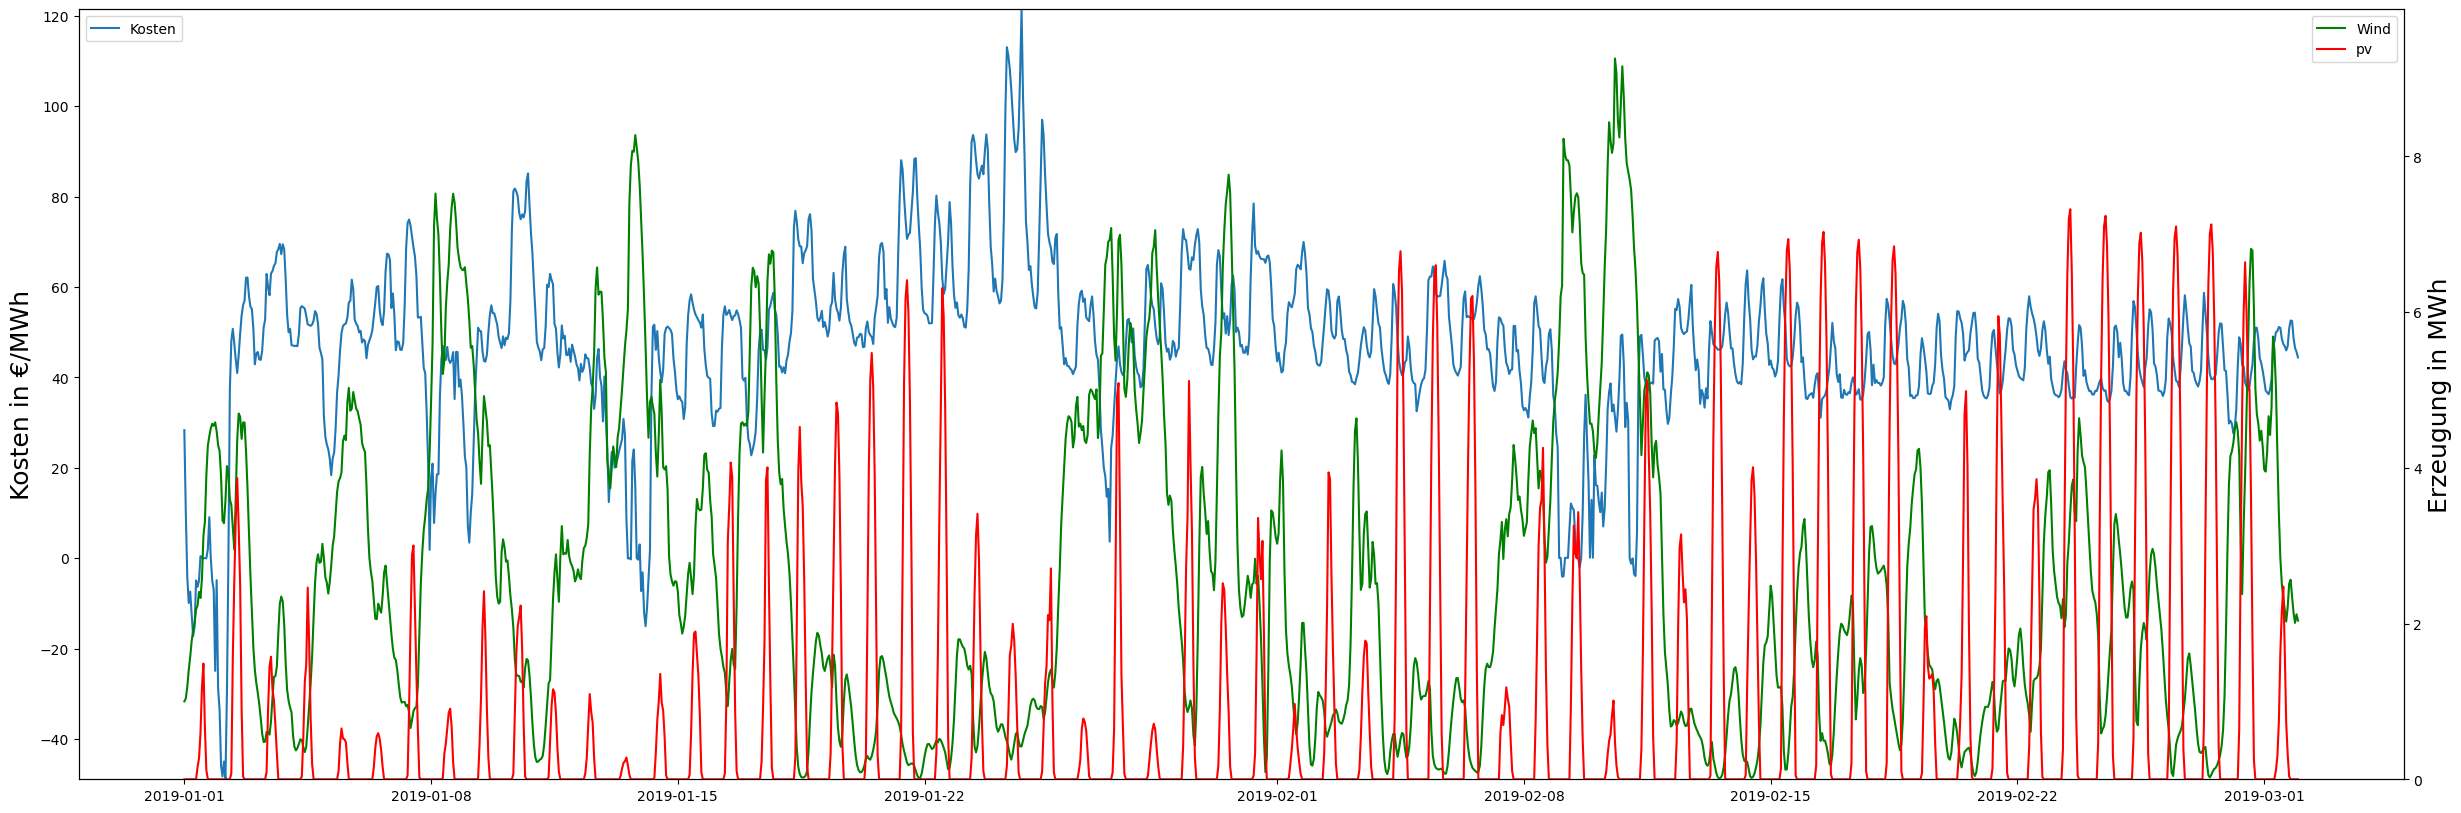

In [86]:
fig, ax1 = plt.subplots(figsize=(30,10))
ax2 = ax1.twinx()

ax1.plot(df_show["time"], df_show["Kosten"], label='Kosten')
ax2.plot(df_show["time"], df_show["wind"], color="g", label='Wind')
ax2.plot(df_show["time"], df_show["pv"], color="r", label='pv')
ax1.set_ylabel("Kosten in €/MWh", fontsize=18)
ax1.set_ylim([df_show.Kosten.min(),df.Kosten.max()])

ax2.set_ylabel("Erzeugung in MWh", fontsize=18)
ax2.set_ylim([0,df.wind.max()])

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

In [87]:
df_halbes_jahr = df[0:4320]

(0.0, 9.889)

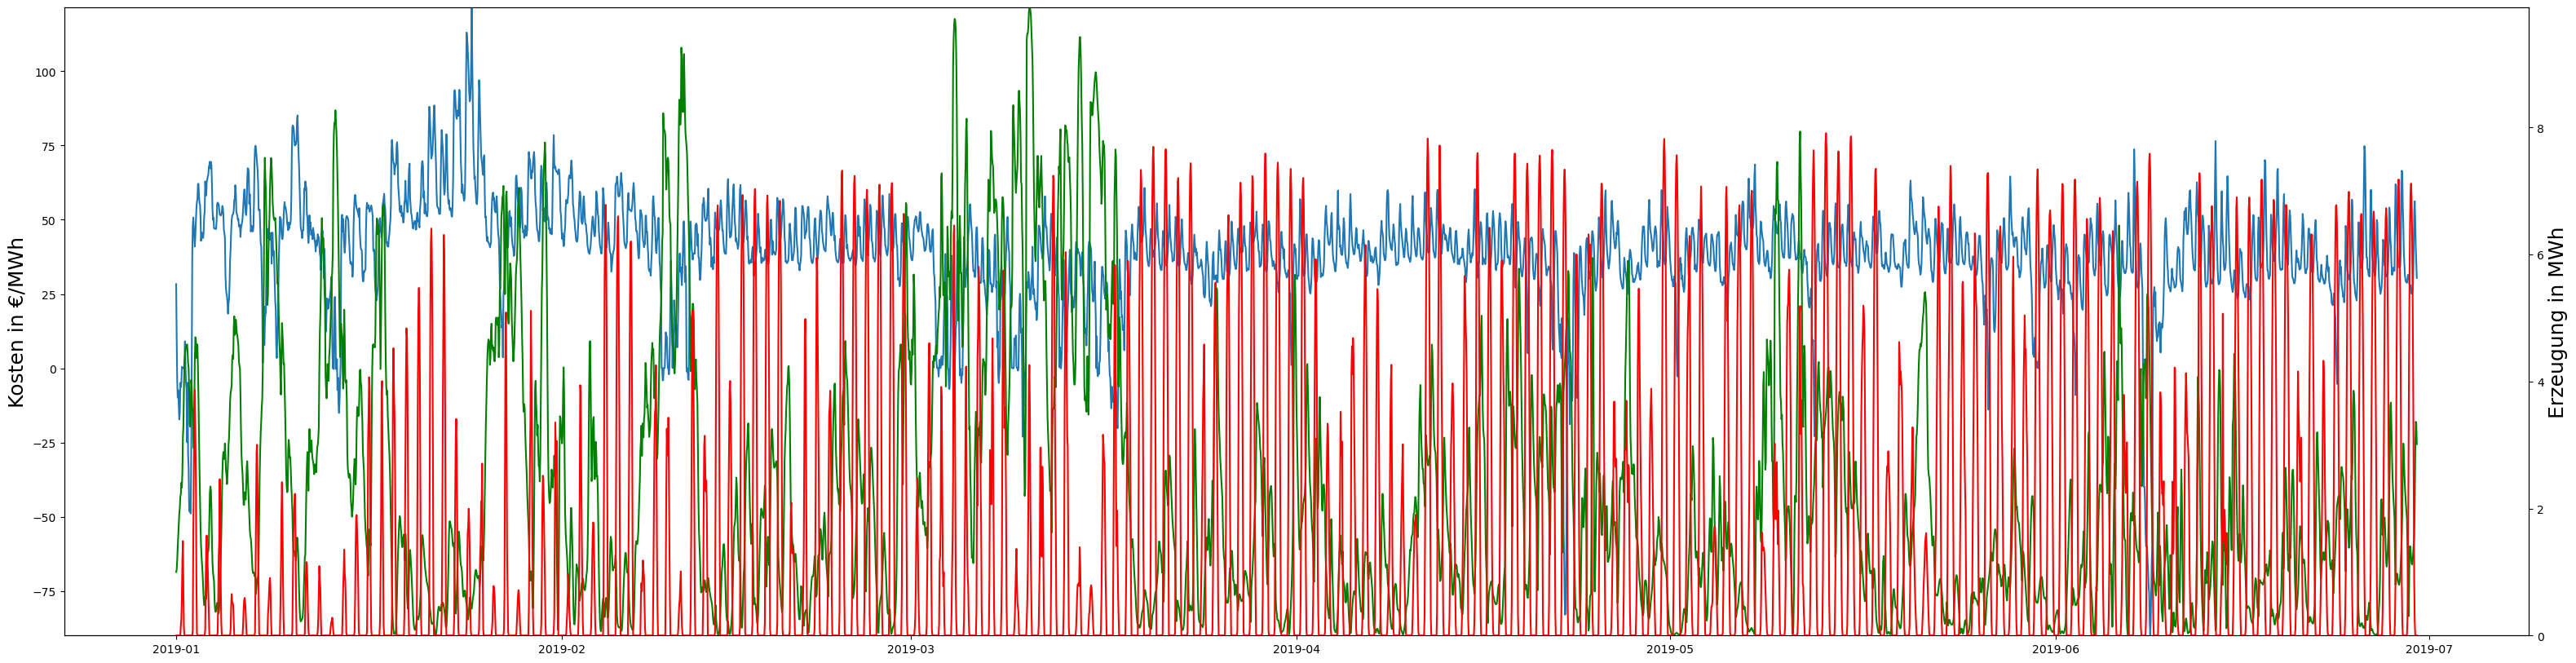

In [88]:
fig, ax1 = plt.subplots(figsize=(39,10))
ax2 = ax1.twinx()

ax1.plot(df_halbes_jahr["time"], df_halbes_jahr["Kosten"], label='Kosten')
ax2.plot(df_halbes_jahr["time"], df_halbes_jahr["wind"], color="g", label='Wind')
ax2.plot(df_halbes_jahr["time"], df_halbes_jahr["pv"], color="r", label='pv')
ax1.set_ylabel("Kosten in €/MWh", fontsize=18)
ax1.set_ylim([df_halbes_jahr.Kosten.min(),df_show.Kosten.max()])

ax2.set_ylabel("Erzeugung in MWh", fontsize=18)
ax2.set_ylim([0,df_halbes_jahr.wind.max()])


#ax1.legend(loc="upper left")
#ax2.legend(loc="upper center")
#ax3.legend(loc="upper right")

b) Profit ohne Speicher
-> heißt: wir besitzen 10 <br>
Annahme: Wir können mit unserer Anlage die maximal mögliche Erzeugung von 10 kV pro Anlage (Wind und PV) erzielen

In [89]:
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0


In [90]:
df['Preis in kWh/€'] = df.Kosten / 1000
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv,Preis in kWh/€
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0,0.02832
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0,0.01007
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0,-0.00408


In [91]:
df['Gewinn_Wind'] = df.wind * df['Preis in kWh/€']
df['Gewinn_PV'] = df.pv * df['Preis in kWh/€']
df['Gesamtgewinn'] = df['Gewinn_PV'] + df['Gewinn_Wind']
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv,Preis in kWh/€,Gewinn_Wind,Gewinn_PV,Gesamtgewinn
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0,0.02832,0.028320,0.0,0.028320
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0,0.01007,0.010453,0.0,0.010453
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0,-0.00408,-0.004831,-0.0,-0.004831


In [92]:
print('Der Gesamtgewinn für das Jahr 2019 beläuft sich auf:', round(df.Gesamtgewinn.sum()), '€')

Der Gesamtgewinn für das Jahr 2019 beläuft sich auf: 1021 €


c) Profit mit Speicher